In [1]:
import warnings
import timeit
import math
import random
import requests
import itertools
import wooldridge
import numpy as np
import pandas as pd
import patsy as ps
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from  pydynpd import regression
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from statsmodels.api import add_constant
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.sandbox.regression.gmm import IVGMM
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook

warnings.filterwarnings('ignore')
%matplotlib inline

# Regressão Linear

#### 1) Um problema de interesse para autoridades de saúde é determinar os efeitos do fumo durante a gravidez na saúde do bebê. Uma medida da saúde do bebê é o peso no nascimento (bwght); um peso no nascimento muito baixo pode colocar o bebê em risco de contrair várias doenças. Uma vez que fatores além do tabagismo que afetam o peso no nascimento provavelmente estão correlacionados com o tabagismo, devemos levar esses fatores em consideração. Por exemplo, uma renda mais alta geralmente resulta em acesso a melhor atendimento pré-natal, bem como melhor nutrição para a mãe. Uma equação que reconhece isso é: $$\text{bwght} = \beta_1 \text{cigs} + \beta_2 \text{faminc} + u$$

In [2]:
bwght = wooldridge.data('bwght')
bwght.head()

,faminc,cigtax,cigprice,bwght,fatheduc,motheduc,parity,male,white,cigs,lbwght,bwghtlbs,packs,lfaminc
0,13.5,16.5,122.300003,109,12.0,12.0,1,1,1,0,4.691348,6.8125,0.0,2.602690
1,7.5,16.5,122.300003,133,6.0,12.0,2,1,0,0,4.890349,8.3125,0.0,2.014903
2,0.5,16.5,122.300003,129,NaN,12.0,2,0,0,0,4.859812,8.0625,0.0,-0.693147
3,15.5,16.5,122.300003,126,12.0,12.0,2,1,0,0,4.836282,7.8750,0.0,2.740840
4,27.5,16.5,122.300003,134,14.0,12.0,2,1,1,0,4.897840,8.3750,0.0,3.314186


##### (i) Qual é o sinal mais provável para $\beta_2$?

Podemos imaginar que $\beta_2 > 0$, pelo raciocínio a priori de que uma maior renda traria melhores cuidados para a mãe durante o pré-natal.

##### (ii) Você acha que cigs e faminc provavelmente estão correlacionados? Explique por que a correlação pode ser positiva ou negativa.

Por um lado, um aumento na renda geralmente aumenta o consumo de um bem, e cigs e faminc podem estar positivamente correlacionados. 
Por outro lado, os rendimentos familiares também são maiores para famílias com mais educação, e a educação e o consumo de cigarros tendem a estar negativamente correlacionados.

In [3]:
bwght.cigs.corr(bwght.faminc)

-0.1730449257358646

##### (iii) Agora, estime a equação com e sem faminc, usando os dados de BWGHT do Wooldridge. Relate os resultados em forma de equação, incluindo o tamanho da amostra e R-quadrado. Discuta seus resultados, focando se  inclusão de faminc muda substancialmente o efeito estimado de cigs em bwght.

In [4]:
# Regressão por OLS sem faminc
formula = 'bwght ~ cigs'
y, X = ps.dmatrices(formula, data=bwght, return_type='dataframe')
model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  bwght   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     32.24
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           1.66e-08
Time:                        20:00:58   Log-Likelihood:                -6135.5
No. Observations:                1388   AIC:                         1.227e+04
Df Residuals:                    1386   BIC:                         1.229e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    119.7719      0.572    209.267      0.0

In [5]:
# Regressão por OLS com faminc
formula = 'bwght ~ cigs + faminc'
y, X = ps.dmatrices(formula, data=bwght, return_type='dataframe')
model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())

"""
O efeito do consumo de cigarros é ligeiramente menor quando faminc é adicionado 
à regressão, mas a diferença não é significativa. Isso ocorre devido ao fato de 
que cigs e faminc não estão muito correlacionados, e o coeficiente em faminc é 
pequeno. (A variável faminc é medida em milhares, então um aumento de $10.000 
na renda de 1988 aumenta o peso de nascimento previsto em apenas 0,93 onças.)
""";

                            OLS Regression Results                            
Dep. Variable:                  bwght   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     21.27
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           7.94e-10
Time:                        20:00:58   Log-Likelihood:                -6130.4
No. Observations:                1388   AIC:                         1.227e+04
Df Residuals:                    1385   BIC:                         1.228e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    116.9741      1.049    111.512      0.0

#### 2) Considere o seguinte modelo para explicar o comportamento do sono:

$$ \text{sleep} = \beta_0 + \beta_1 \text{totwork} + \beta_2 \text{educ} + \beta_3 \text{age} + \beta_4 \text{age}^2 + \beta_5 \text{yngkid} + \beta_6 \text{male} + u

##### (i) Escreva um modelo que permita que a variância de u difira entre homens e mulheres. A variância não deve depender de outros fatores.

No modelo pedido, a variância de u deve depender apenas do gênero. Portanto, temos:
$$Var(u|totwrk,educ,age,yngkid,male) = Var(u|male) = \delta_0 + \delta_1 male$$
A variância para mulheres será apenas $\delta_0$ e para homens $\delta_0 + \delta_1$. A diferença entre variâncias será $\delta_1$.

##### (ii) Use os dados em SLEEP75 (Wooldridge) para estimar os parâmetros do modelo para heteroscedasticidade. (Você precisa primeiro estimar a equação de sono por Mínimos Quadrados Ordinários (OLS) para obter os resíduos de OLS.) A variância estimada de u é maior para homens ou para mulheres? 

##### (iii) A variância de u é estatisticamente diferente para homens e mulheres?

In [6]:
sleep75 = wooldridge.data('sleep75')

In [7]:
# Estimando sono por OLS
formula = 'sleep ~ totwrk + educ + age + agesq + yngkid + male'
y, X = ps.dmatrices(formula, data=sleep75, return_type='dataframe')
model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     16.30
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           1.28e-17
Time:                        20:00:58   Log-Likelihood:                -5259.3
No. Observations:                 706   AIC:                         1.053e+04
Df Residuals:                     699   BIC:                         1.056e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3840.8521    239.414     16.043      0.0

In [8]:
# Regredindo o resíduo ao quadrado em male
sleep75["u_sq"] = model.resid ** 2
formula = 'u_sq ~ male'
y, X = ps.dmatrices(formula, data=sleep75, return_type='dataframe')
model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())

"""
Vemos que o intercepto para "male" na regressão com o resíduo quadrado como 
variável dependente é negativo, o que indicaria que a variância estimada é 
menor para homens.

Porém, o resultado de menor variância no erro para homens não é significante, 
pois temos uma estatística t de apenas -1.06 (p-valor 0.291: não é significante 
até em um nível de 20%)
""";

                            OLS Regression Results                            
Dep. Variable:                   u_sq   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.117
Date:                Tue, 04 Jul 2023   Prob (F-statistic):              0.291
Time:                        20:00:58   Log-Likelihood:                -10032.
No. Observations:                 706   AIC:                         2.007e+04
Df Residuals:                     704   BIC:                         2.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.894e+05   2.05e+04      9.216      0.0

#### 3) Os dados em FERTIL2 (wooldridge) incluem, para mulheres em Botsuana durante 1988, informações sobre o número de filhos, anos de educação, idade e variáveis de status religioso e econômico.

In [9]:
fertil2 = wooldridge.data('fertil2')
fertil2.head()

,mnthborn,yearborn,age,electric,radio,tv,bicycle,educ,ceb,agefbrth,...,heduc,agesq,urban,urb_educ,spirit,protest,catholic,frsthalf,educ0,evermarr
0,5,64,24,1.0,1.0,1.0,1.0,12,0,NaN,...,NaN,576,1,12,0,0,0,1,0,0
1,1,56,32,1.0,1.0,1.0,1.0,13,3,25.0,...,12.0,1024,1,13,0,0,0,1,0,1
2,7,58,30,1.0,0.0,0.0,0.0,5,1,27.0,...,7.0,900,1,5,1,0,0,0,0,1
3,11,45,42,1.0,0.0,1.0,0.0,4,3,17.0,...,11.0,1764,1,4,0,0,0,0,0,1
4,5,45,43,1.0,1.0,1.0,1.0,11,2,24.0,...,14.0,1849,1,11,0,1,0,1,0,1


##### (i) Estime o modelo abaixo por Mínimos Quadrados Ordinários (OLS) e interprete as estimativas. Em particular, mantendo a idade fixa, qual é o efeito estimado de mais um ano de educação na fertilidade? Se 100 mulheres recebessem mais um ano de educação, quantos filhos a menos elas esperariam ter?

$$\text{children} = \beta_0 + \beta_1 \text{educ} + \beta_2 \text{age} + \beta_3 \text{age}^2 + u$$

In [10]:
formula = 'children ~ educ + age + agesq'
y, X = ps.dmatrices(formula, data=fertil2, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

"""
Mantendo a idade fixa, cada ano de educação a mais resultaria em 0.91 filhos a menos. 
Isso significa que, para um grupo de 100 mulheres de mesma idade que obtiverem mais 
um ano de educação, esperaríamos 9 filhos a menos.
""";

                            OLS Regression Results                            
Dep. Variable:               children   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     1915.
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:00:58   Log-Likelihood:                -7835.6
No. Observations:                4361   AIC:                         1.568e+04
Df Residuals:                    4357   BIC:                         1.570e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1383      0.241    -17.200      0.0

##### (ii) A variável frsthalf é uma variável dummy que é igual a um se a mulher nasceu durante os primeiros seis meses do ano. Assumindo que frsthalf não está correlacionada com o termo de erro da parte (i), mostre que frsthalf é um candidato razoável para IV (variável instrumental) para educ. (Dica: Você precisa fazer uma regressão.)

In [11]:
# Testamos o potencial de IV usando a forma reduzida de educ.
# Queremos que o coeficiente de frsthalf seja diferente de zero e significante.

formula = 'educ ~ age + agesq + frsthalf'
y, X = ps.dmatrices(formula, data=fertil2, return_type='dataframe')
model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())

"""
Com os resultados, vemos que mulheres que nascem na primeira metade do ano têm uma 
previsão de quase um ano a menos de educação (-0.852), quando a idade é mantida fixa.
A estatística t também é alta em módulo (7.5), o que indica correlação forte com educ.
Finalmente, uma vez que assumimos que frsthalf não é correlacionada ao erro, ela se demonstra
uma boa candidata a IV para educ.
""";

                            OLS Regression Results                            
Dep. Variable:                   educ   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     175.2
Date:                Tue, 04 Jul 2023   Prob (F-statistic):          3.01e-107
Time:                        20:00:58   Log-Likelihood:                -11905.
No. Observations:                4361   AIC:                         2.382e+04
Df Residuals:                    4357   BIC:                         2.384e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.6929      0.598     16.207      0.0

##### (iii) Estime o modelo da parte (i) usando frsthalf como um IV para educ. Compare o efeito estimado da educação com a estimativa OLS da parte (i).

In [12]:
formula = 'children ~ educ + age + agesq'
y, X = ps.dmatrices(formula, data=fertil2, return_type='dataframe')
df_iv = fertil2[['children', 'educ', 'age', 'agesq', 'frsthalf']].copy()

# Variável dependente
endog = df_iv['children']
# Variáveis independentes (tanto endógenas quanto exógenas)
exog = df_iv[['educ', 'age', 'agesq']]
exog = sm.add_constant(exog)
# Instrumentos (tanto instrumentos quando exógenas)
instr = df_iv[['frsthalf', 'age', 'agesq']]
instr = sm.add_constant(instr)

model = IV2SLS(endog=endog, exog=exog, instrument=instr).fit()
print(model.summary())

"""
O efeito estimado da educação na fertilidade agora é muito maior.
Naturalmente, o erro padrão para a variável educ aumentou, tal como
seu intervalo de confiança.
""";

                          IV2SLS Regression Results                           
Dep. Variable:               children   R-squared:                       0.550
Model:                         IV2SLS   Adj. R-squared:                  0.550
Method:                     Two Stage   F-statistic:                     1765.
                        Least Squares   Prob (F-statistic):               0.00
Date:                Tue, 04 Jul 2023                                         
Time:                        20:00:58                                         
No. Observations:                4361                                         
Df Residuals:                    4357                                         
Df Model:                           3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3878      0.548     -6.180      0.0

In [13]:
# O Método de Momentos Generalizado chega em resultados semelhantes:
model = IVGMM(endog=endog, exog=exog, instrument=instr).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                                IVGMM Results                                 
Dep. Variable:               children   Hansen J:                    4.161e-08
Model:                          IVGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:

##### (iv) Adicione as variáveis binárias electric, tv e bicycle ao modelo e assuma que essas variáveis são exógenas. Estime a equação por OLS e 2SLS e compare os coeficientes estimados de educ. Interprete o coeficiente de tv e explique por que a posse de televisão tem um efeito negativo na fertilidade.

In [14]:
# Estimando children por OLS
formula = 'children ~ educ + age + agesq + electric + tv + bicycle'
y, X = ps.dmatrices(formula, data=fertil2, return_type='dataframe')
model1 = sm.OLS(y, X, missing="drop").fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               children   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     984.9
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:00:59   Log-Likelihood:                -7789.3
No. Observations:                4356   AIC:                         1.559e+04
Df Residuals:                    4349   BIC:                         1.564e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3898      0.240    -18.267      0.0

In [15]:
formula = 'children ~ educ + age + agesq + electric + tv + bicycle'
y, X = ps.dmatrices(formula, data=fertil2, return_type='dataframe')
df_iv = fertil2[['children', 'educ', 'age', 'agesq', 'frsthalf', 'electric', 'tv', 'bicycle']].copy()
df_iv = df_iv.dropna()

# Variável dependente
endog = df_iv['children']
# Variáveis independentes (tanto endógenas quanto exógenas)
exog = df_iv[['educ', 'age', 'agesq', 'electric', 'tv', 'bicycle']]
exog = sm.add_constant(exog)
# Instrumentos (tanto instrumentos quando exógenas)
instr = df_iv[['frsthalf', 'age', 'agesq','electric', 'tv', 'bicycle']]
instr = sm.add_constant(instr)

model2 = IV2SLS(endog=endog, exog=exog, instrument=instr).fit()
print(model2.summary())

                          IV2SLS Regression Results                           
Dep. Variable:               children   R-squared:                       0.558
Model:                         IV2SLS   Adj. R-squared:                  0.557
Method:                     Two Stage   F-statistic:                     921.7
                        Least Squares   Prob (F-statistic):               0.00
Date:                Tue, 04 Jul 2023                                         
Time:                        20:00:59                                         
No. Observations:                4356                                         
Df Residuals:                    4349                                         
Df Model:                           6                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5913      0.645     -5.567      0.0

In [16]:
print('OLS - 1')
print(model.summary().tables[1])
print('OLS - 2')
print(model1.summary().tables[1])
print('IV2SLS')
print(model2.summary().tables[1])

"""
Adicionar eletricidade, televisão e bicicleta ao modelo reduz o efeito estimado 
da educação em ambos os casos, mas não muito. Na equação estimada pelo OLS, 
o coeficiente da televisão implica que, com outros fatores fixos, uma família com
televisão terá -0.25 filhos a menos que uma sem televisão. 

A posse de televisão pode ser um indicador de diferentes coisas, incluindo renda. 
Uma interpretação causal é que a TV fornece uma forma alternativa de recreação. 
Curiosamente, o efeito da posse de TV é estatisticamente insignificante na equação 
estimada por IV (mesmo que não estejamos usando um IV para a TV). 

O coeficiente da eletricidade também é muito reduzido em magnitude na estimativa por IV. 
As quedas desses coeficientes sugerem que um modelo linear pode não ser a 
melhor forma funcional, o que não seria surpreendente, já que o número de filhos 
é uma variável de contagem.
""";

OLS - 1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3879      0.545     -6.217      0.000      -4.456      -2.320
educ          -0.1715      0.052     -3.275      0.001      -0.274      -0.069
age            0.3236      0.020     15.998      0.000       0.284       0.363
agesq         -0.0027      0.000     -7.587      0.000      -0.003      -0.002
OLS - 2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3898      0.240    -18.267      0.000      -4.861      -3.919
educ          -0.0767      0.006    -12.075      0.000      -0.089      -0.064
age            0.3402      0.016     20.692      0.000       0.308       0.372
agesq         -0.0027      0.000    -10.010      0.000      -0.003      -0.002
electric      -0.3027      0.076    

# Séries Temporais

#### 1) Use os dados “JohnsonJohnson: Quarterly Earnings per Johnson & Johnson” Disponíveis [aqui](https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/jj.csv)

##### a) Plote os dados e conclua que os dados provavelmente são não estacionários.
##### b) Use o teste de Dickey-Fuller para confirmar sua suspeita.
##### c) Calcule a primeira diferenca para tornar os dados estacionários.
##### d) Confirme usando Dickey-Fuller que os dados diferenciados são realmente estacionários.
##### e) Plote as funções de autocorrelação e autocorrelação parcial para ter uma ideia do tipo de série temporal que você está lidando.
##### f) Use o AIC e BIC para sugerir ordens para o modelo que mais se adequa aos dados.
##### g) Relate o modelo com a ordem que mais se adequa ao AIC e BIC.
##### h) Cheque se os resíduos do modelo apresentam autocorrelação. Use o teste de Ljung-Box.

In [17]:
data = pd.read_csv('https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


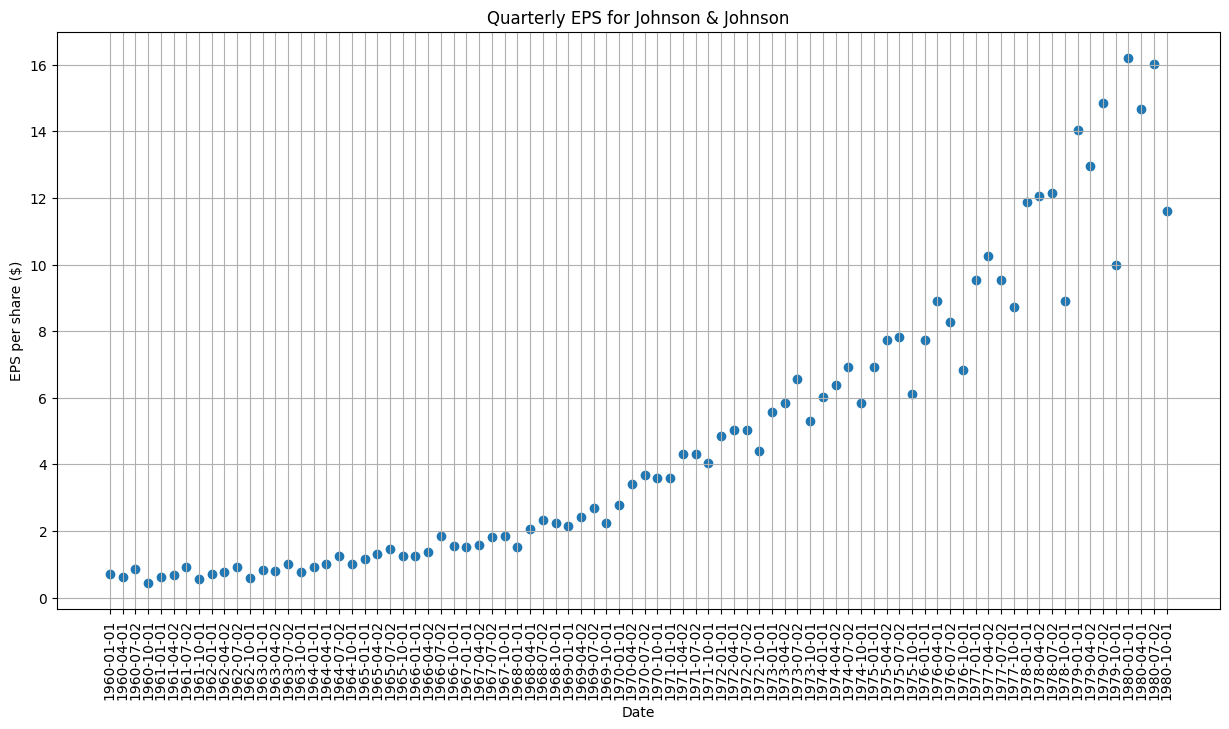

In [18]:
# Visualizando nossos dados

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Podemos observar tanto uma tendência quanto uma mudança na variância da série

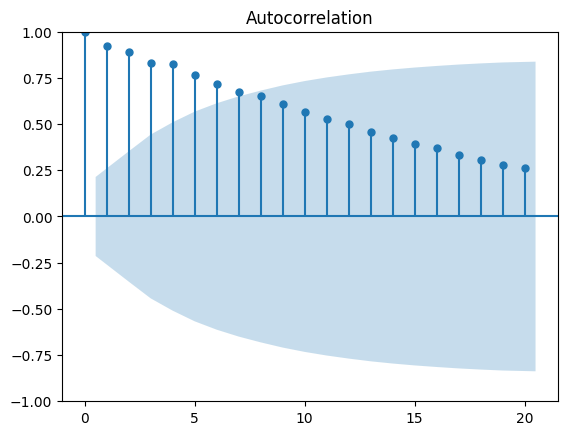

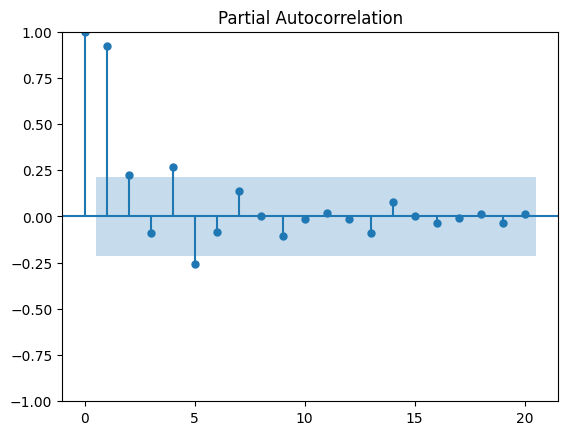

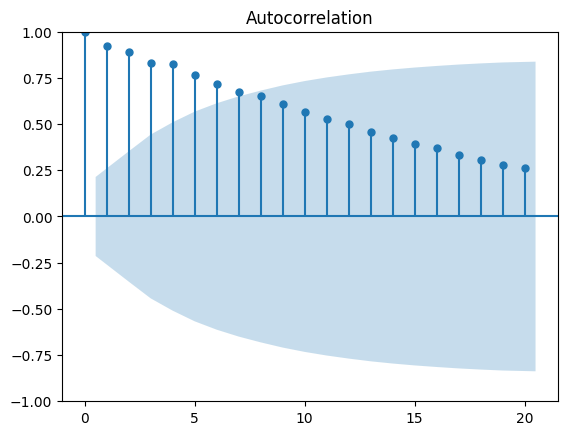

In [19]:
# Plotando as funções ACF e PACF:

plot_pacf(data['data'])
plot_acf(data['data'])

# Gráfico de ACF: (ajuda a determinar a ordem do componente MA em um modelo ARIMA)

# O gráfico de ACF mede a correlação entre uma série temporal e seus valores defasados. Ele mostra os coeficientes de correlação em diferentes defasagens.
# No gráfico de ACF, o eixo x representa a defasagem e o eixo y representa o coeficiente de correlação. 
# Um declínio gradual no gráfico de ACF indica uma série temporal não estacionária, enquanto uma queda abrupta ou interrupção sugere estacionariedade.
# O gráfico de ACF ajuda a determinar a ordem do componente MA em um modelo ARIMA. A defasagem na qual o gráfico de ACF é interrompido é um indicador da ordem MA.

#Gráfico de PACF: (ajuda a determinar a ordem do componente AR em um modelo ARIMA)

# O gráfico de PACF mostra a correlação parcial entre uma série temporal e seus valores defasados, removendo a influência de defasagens intermediárias.

# Aparentemente, não há forma clara de determinar a ordem correta para os processos
# AR e MA. Esses plots também são uma indicação clara de não-estacionariedade.

In [20]:
# Podemos provar a não-estacionariedade com o teste de Dickey-Fuller aumentado:

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# Se o p-valor do teste ADF é maior que 0.05, não podemos rejeitar a hipótese nula 
# de que a série é não-estacionária. 

# Observamos que é o caso, com um p-valor de 1.
# Portanto, precisamos aplicar alguma transformação/diferenciação para remover a
# tendência e mudança de variância da série.

ADF Statistic: 2.742016573457476
p-value: 1.0


In [21]:
# Aplicamos logaritmo e diferenciamos a série:

data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])
data.head()

,date,data
1,1960-04-01,-0.119545
2,1960-07-02,0.299517
3,1960-10-01,-0.658462
4,1961-01-01,0.326684
5,1961-04-02,0.123233


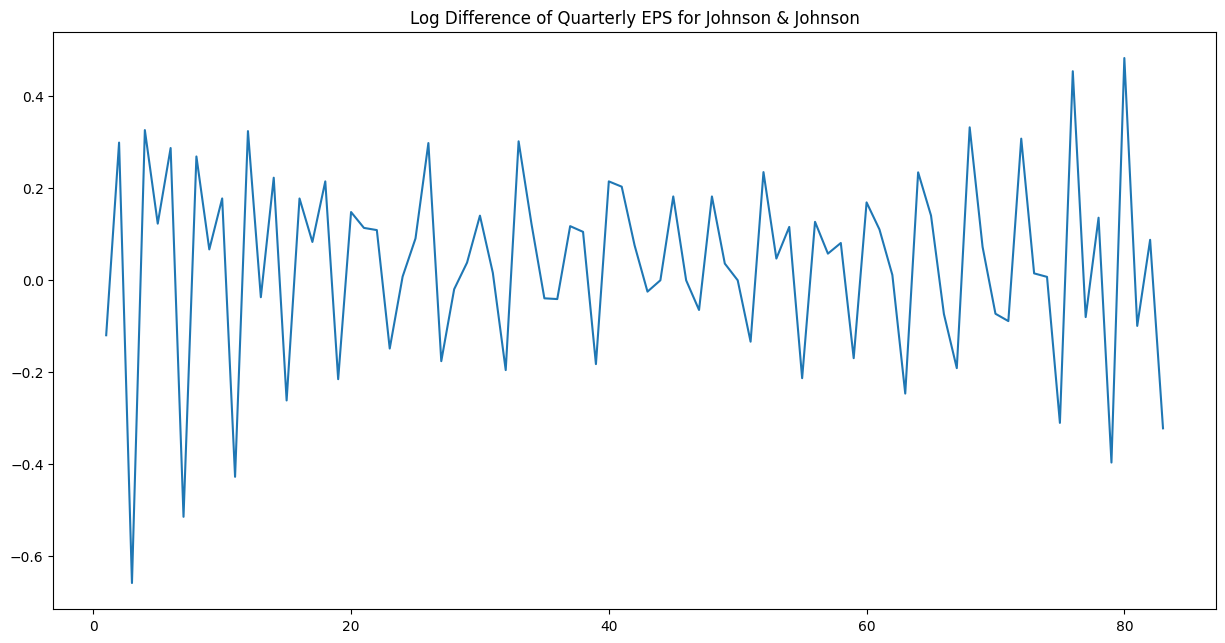

In [22]:
# Plotamos os dados transformados:

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

# Aparentemente, a tendência e mudança de variância foram removidas.

In [23]:
# Nos certificamos reaplicando o teste de Dickey-Fuller aumentado:

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# Dessa vez, o p-valor é menor que 0.05, então podemos rejeitar a hipótese nula
# de que a série é não-estacionária, assumindo então a estacionariedade.

ADF Statistic: -4.317043945811818
p-value: 0.00041497314044409604


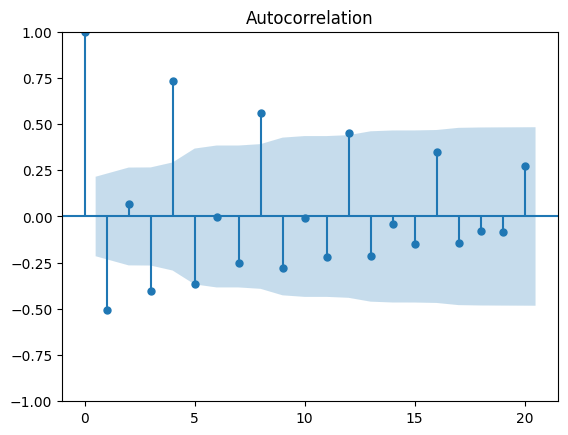

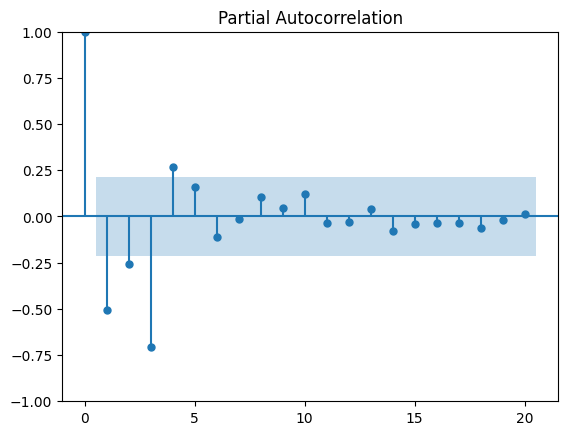

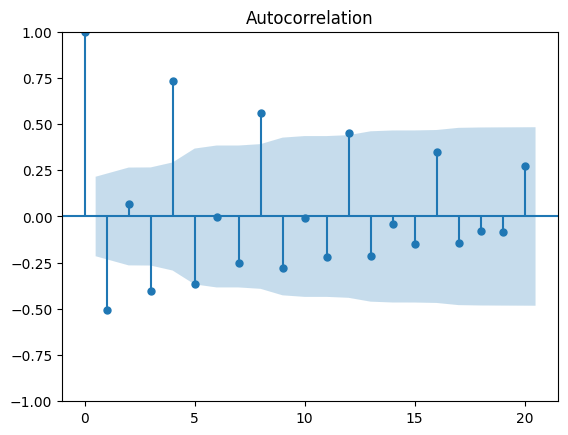

In [24]:
# Novamente, plotamos as funções ACF e PACF na tentativa de determinar a ordem
# correta para os processos AR e MA:

plot_pacf(data['data'])
plot_acf(data['data'])

# Examinando os plots, aparentemente temos um processo AR de ordem 3 ou 4.
# Porém, a ACF não é informativa e vemos uma forma aparentemente sinusoidal.

In [25]:
# Podemos testar diferentes combinações de ordens para o modelo ARIMA e escolher
# a que minimiza o AIC (Akaike's Information Criterion):

def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

# Esta função resulta em um dataframe que lista as ordens testadas e o AIC correspondente,
# ordenado do menor para o maior AIC (melhor modelo no topo).

In [26]:
# Testamos todas as combinações de ordens de 0 a 6 para p, q, mantendo a ordem de diferenciação 1.

ps = range(0, 6, 1)
d = 1
qs = range(0, 6, 1)

parameters_list = list(itertools.product(ps, qs))
order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=data['data'])
result_df

  0%|          | 0/36 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(3, 1, 3)",-142.041679
1,"(3, 1, 1)",-140.470696
2,"(3, 1, 4)",-140.460728
3,"(4, 1, 1)",-140.441386
4,"(4, 1, 3)",-140.186840
5,"(3, 1, 2)",-139.787850
6,"(5, 1, 1)",-139.721942
7,"(3, 1, 5)",-138.841292
8,"(4, 1, 4)",-138.765769
9,"(5, 1, 2)",-138.238719


In [27]:
# Da função, obtemos que um dos melhores modelos é o ARIMA(3, 1, 3). Isso sugere que
# o modelo ARIMA tem um processo AR(3) e um processo MA(3).

best_model = SARIMAX(data['data'], order=(3,1,3)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.15720D-01    |proj g|=  1.42500D+00

At iterate    5    f= -9.19804D-01    |proj g|=  2.80782D-01

At iterate   10    f= -9.24710D-01    |proj g|=  4.67412D-02

At iterate   15    f= -9.27071D-01    |proj g|=  5.53495D-01

At iterate   20    f= -9.31371D-01    |proj g|=  1.86410D-01

At iterate   25    f= -9.39292D-01    |proj g|=  9.38312D-02

At iterate   30    f= -9.39968D-01    |proj g|=  1.26601D-03

At iterate   35    f= -9.39976D-01    |proj g|=  3.68096D-03

At iterate   40    f= -9.40010D-01    |proj g|=  1.23653D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


In [28]:
print(best_model.summary())

# Do sumário do nosso modelo, podemos ver os valores de todos os coeficientes e p-valores.
# Observem que o parâmetro para o processo MA com atraso 2 não é significativo.
# Mesmo assim, vamos mantê-lo no modelo por enquanto.

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   83
Model:               SARIMAX(3, 1, 3)   Log Likelihood                  78.021
Date:                Tue, 04 Jul 2023   AIC                           -142.042
Time:                        20:01:05   BIC                           -125.195
Sample:                             0   HQIC                          -135.278
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9948      0.054    -18.288      0.000      -1.101      -0.888
ar.L2         -0.9744      0.051    -19.066      0.000      -1.075      -0.874
ar.L3         -0.9420      0.031    -30.488      0.0

A série temporal pode ser modelada como:
$$y'_t = -0.99 t'_{t-1} -0.97y'_{t-2}-0.94y'_{t-3}-0.68\epsilon_{t-1}+0.1\epsilon_{t-2}-0.31\epsilon_{t-3}$$
Onde $\epsilon$ é ruído com variância 0.0077.

In [29]:
# Idealmente, os resíduos do modelo devem ser ruído branco, ou seja, não devem ter
# autocorrelação e média zero. Podemos testar isso com o teste de Ljung-Box:

ljungbox_result = acorr_ljungbox(best_model.resid)
ljung_box = ljungbox_result['lb_stat'].tolist()
p_value = ljungbox_result['lb_pvalue'].tolist()
print(f'Ljung-Box test: {ljung_box}')
print(f'p-value: {p_value}')

# Aqui, a hipótese nula é que os dados são independentes. Se o p-valor é menor que 0.05,
# rejeitamos a hipótese nula e concluímos que os dados não são independentes.
# Neste caso, o p-valor é maior que 0.05 para a maioria dos lags, então não podemos rejeitar
# a hipótese nula e concluímos que os resíduos são independentes.

Ljung-Box test: [5.929534079576443, 5.950003027736902, 6.179512046719039, 6.957149435380869, 6.957160514346258, 6.983056468102175, 9.552039448573522, 9.563201505200007, 9.775947213529601, 10.682835131510318]
p-value: [0.014889177976811519, 0.05104735672511305, 0.1031958114702851, 0.13817008326942024, 0.22384588264001395, 0.32241697293836746, 0.2154114341585657, 0.29703054124063466, 0.3689263335988474, 0.38275592071417125]


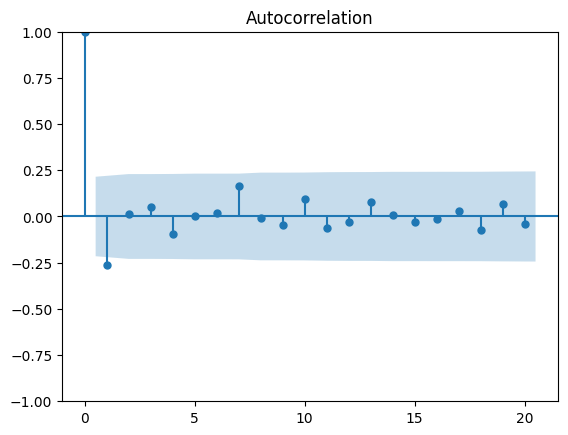

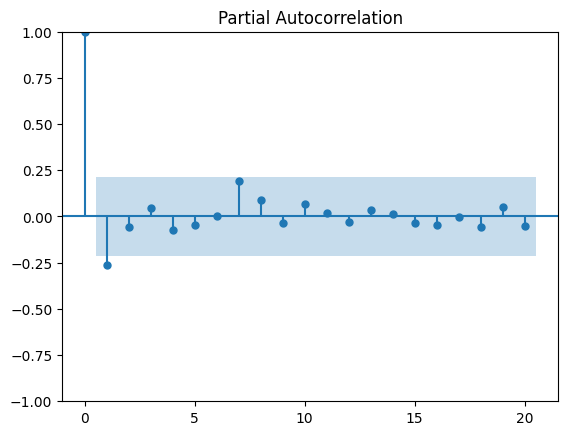

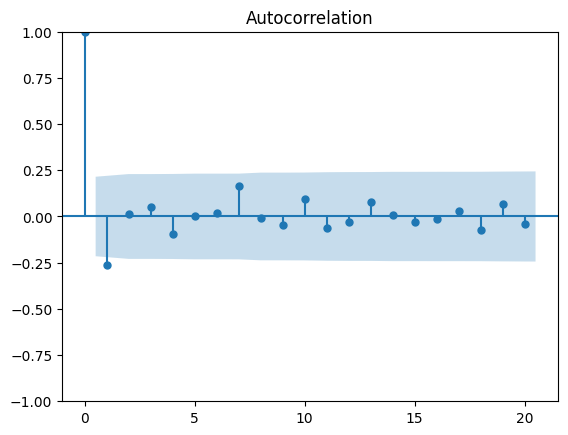

In [30]:
# Podemos informar essa decisão com os plots ACF e PACF dos resíduos:

plot_pacf(best_model.resid)
plot_acf(best_model.resid)

# Estes plots confirmam que os resíduos são independentes e se assemelham a ruído branco.
# Nosso modelo está pronto para previsões!

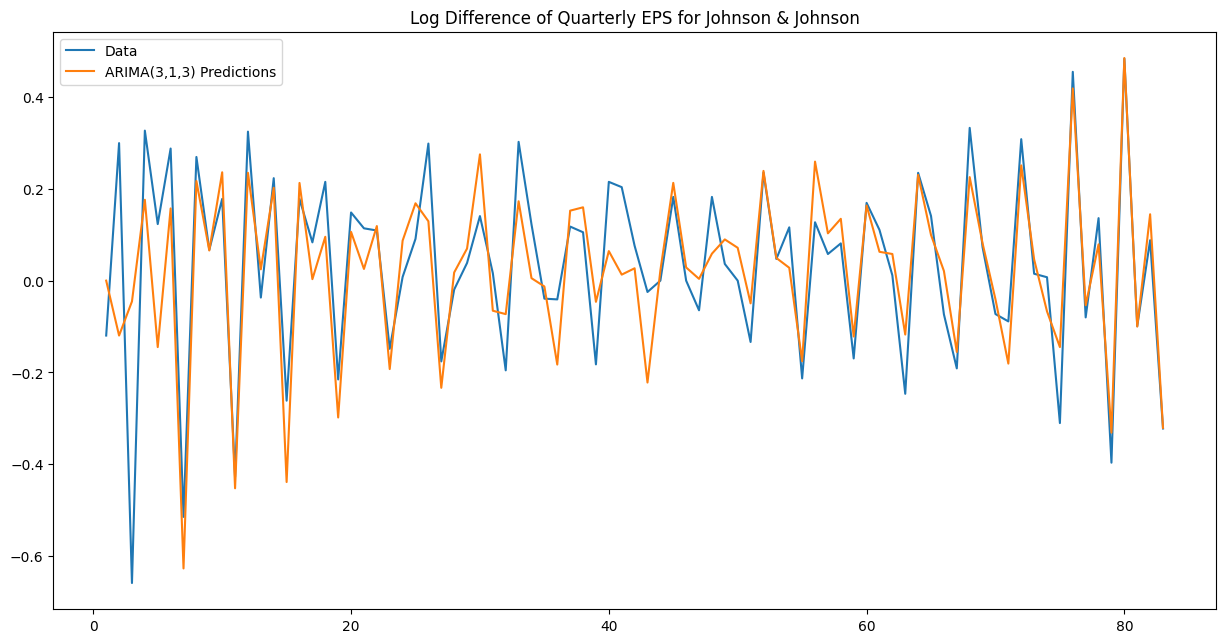

In [31]:
# Primeiro, vamos plotar os dados originais e as previsões do modelo:

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'], label='Data')
plt.plot(best_model.predict(), label='ARIMA(3,1,3) Predictions')
plt.legend()
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

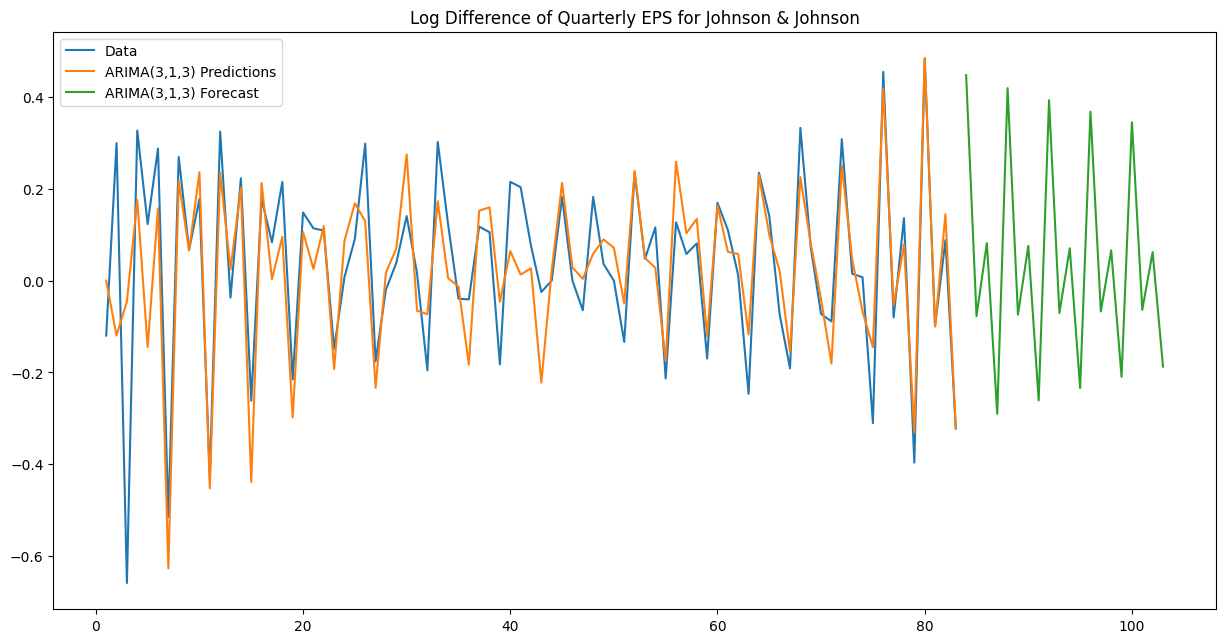

In [32]:
# Agora, vamos prever os próximos 20 valores:

plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'], label='Data')
plt.plot(best_model.predict(), label='ARIMA(3,1,3) Predictions')
plt.plot(best_model.forecast(20), label='ARIMA(3,1,3) Forecast')
plt.legend()
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()


#### 2) Use a base de dados EARNS (do Wooldridge) para explorar o efeito da produtividade no salário.

In [33]:
earns = wooldridge.data('earns')
earns['diff_lhrwage'] = earns['lhrwage'].diff()
earns['diff_loutphr'] = earns['loutphr'].diff()
earns.head(20)

,year,wkearns,wkhours,outphr,hrwage,lhrwage,loutphr,t,ghrwage,goutphr,ghrwge_1,goutph_1,goutph_2,lwkhours,diff_lhrwage,diff_loutphr
0,1947,123.519997,40.299999,51.400002,3.065012,1.120052,3.939638,1,NaN,NaN,NaN,NaN,NaN,3.696352,NaN,NaN
1,1948,123.430000,40.000000,53.299999,3.085750,1.126795,3.975936,2,0.006743,0.036298,NaN,NaN,NaN,3.688879,0.006743,0.036298
2,1949,127.839996,39.400002,54.200001,3.244670,1.177014,3.992681,3,0.050219,0.016745,0.006743,0.036298,NaN,3.673766,0.050219,0.016745
3,1950,133.830002,39.799999,57.700001,3.362563,1.212703,4.055257,4,0.035690,0.062576,0.050219,0.016745,0.036298,3.683867,0.035690,0.062576
4,1951,134.869995,39.900002,59.400002,3.380200,1.217935,4.084294,5,0.005231,0.029037,0.035690,0.062576,0.016745,3.686376,0.005231,0.029037
5,1952,138.470001,39.900002,60.700001,3.470426,1.244277,4.105944,6,0.026342,0.021649,0.005231,0.029037,0.062576,3.686376,0.026342,0.021649
6,1953,144.580002,39.599998,62.099998,3.651010,1.295004,4.128746,7,0.050727,0.022802,0.026342,0.021649,0.029037,3.678829,0.050727,0.022802
7,1954,145.320007,39.099998,63.000000,3.716624,1.312816,4.143135,8,0.017812,0.014389,0.050727,0.022802,0.021649,3.666122,0.017812,0.014389
8,1955,153.210007,39.599998,64.800003,3.868940,1.352980,4.171306,9,0.040165,0.028171,0.017812,0.014389,0.022802,3.678829,0.040165,0.028171
9,1956,157.899994,39.299999,65.199997,4.017812,1.390737,4.177459,10,0.037757,0.006154,0.040165,0.028171,0.014389,3.671225,0.037757,0.006154


##### a) Rode a regressão e calcule o $R^2$:

$$ log(\text{hrwage}_t) = \beta_0 + \beta_1 log(\text{output}_t) + u_t

In [34]:
import patsy as ps

formula = 'lhrwage ~ loutphr'
y,X = ps.dmatrices(formula,data=earns, return_type='dataframe')
model = sm.OLS(y,X)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                lhrwage   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     311.9
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           3.32e-20
Time:                        20:01:06   Log-Likelihood:                 61.499
No. Observations:                  41   AIC:                            -119.0
Df Residuals:                      39   BIC:                            -115.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5344      0.172     -8.938      0.0

##### b) Rode a mesma regressão adicionando uma tendência.

In [35]:
formula = 'lhrwage ~ loutphr + t'
y,X = ps.dmatrices(formula, data=earns, return_type='dataframe')
model = sm.OLS(y,X)
results=model.fit()
print(results.summary())

# A inclusão da tendência causa um aumento em R2 ajustado.
# Porém, a elasticidade estimada parece ser grande demais: O modelo nos indica que 1% de aumento na produtividade
# Aumenta o salário real em cerca de 1,64%. Como o erro padrão é muito pequeno, o intervalo de confiança de 95%
# exclui facilmente uma elasticidade unitária. Os resultdos devem ser vistos com cautela e vale a pena testar
# A estacionariedade da série.

                            OLS Regression Results                            
Dep. Variable:                lhrwage   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     641.2
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           5.27e-30
Time:                        20:01:06   Log-Likelihood:                 89.196
No. Observations:                  41   AIC:                            -172.4
Df Residuals:                      38   BIC:                            -167.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3285      0.374    -14.230      0.0

##### c) Faça o teste de Dickey-Fuller e no caso de evidência de não-estacionariedade, rode a mesma regressão usando as primeiras diferenças. Discuta os resultados.

In [36]:
# O teste de Dickey-Fuller é utilizado para avaliar a estacionariedade de uma série temporal. 
# Neste caso, investigamos: "lhrwage", "loutphr", "ghrwage" e "goutphr". 

def adf_test(series, data_string, regression_types):
    print("")
    print("Data set:", data_string)
    for regression in regression_types:
        print("===========================================")
        print("Regression type:", regression)
        result = adfuller(
            series,
            regression=regression,  
            autolag="AIC",
            regresults=True,
            store=True,
        )  
        print("pvalue:", result[1])
        #print(result[3].resols.summary())
    return result
    
for series_str in ["lhrwage", "loutphr"]:
    series=earns[series_str].dropna()
    result=adf_test(series,series_str, ['ctt','ct','c'])

# A hipótese nula do teste de Dickey-Fuller é que a série é não estacionária (raiz unitária).
# Se o p-valor for menor que 0,05, há evidências suficientes para rejeitar a hipótese nula. 
# Nesse caso, a série seria considerada estacionária.

# Temos três tipos de regressão no teste DF: "ctt", "ct" e "c".
# "ctt" constant, trend, trend2: permite testar se uma série temporal possui uma tendência não linear.
# "ct" constant, trend: permite testar se uma série temporal possui uma tendência linear.
# "c" constant: permite testar se uma série temporal possui uma média constante.

# as séries "lhrwage" e "loutphr" apresentaram um valor-p significativo para a regressão C, mas
# os altos p-valores para as regressões CT e CTT são suficientes para suspeitarmos que a série
# tem raiz unitária (não é estacionária).



Data set: lhrwage
Regression type: ctt
pvalue: 0.08309971055550769
Regression type: ct
pvalue: 0.9921143025379687
Regression type: c
pvalue: 0.031839041099054784

Data set: loutphr
Regression type: ctt
pvalue: 0.6170497626774258
Regression type: ct
pvalue: 0.8789156050247422
Regression type: c
pvalue: 0.010959047153766147


In [37]:
for series_str in ["ghrwage", "goutphr"]:
    series=earns[series_str].dropna()
    result=adf_test(series,series_str, ['ctt','ct','c'])


Data set: ghrwage
Regression type: ctt
pvalue: 2.730116857971716e-05
Regression type: ct
pvalue: 3.4274950190257274e-06
Regression type: c
pvalue: 0.6902326842399048

Data set: goutphr
Regression type: ctt
pvalue: 0.00014013901587848782
Regression type: ct
pvalue: 1.9709145985612305e-05
Regression type: c
pvalue: 6.839983800065604e-05


In [38]:
# Uma vez que as séries diferenciadas são estacionárias, podemos estimar o modelo com elas:

y,X = ps.dmatrices('ghrwage ~ goutphr',data=earns, return_type='dataframe')
model = sm.OLS(y,X)
results=model.fit()
print(results.summary())

# Agora, estima-se que um aumento de 1% da produtividade aumenta os salários reais em cerca de 0,81%, e a estimativa não é, estatisticamente, diferente de 1.
# o R2 ajustado mostra que o crescimento na produtividade explica cerca de 35% do crescimento nos salários reais.

                            OLS Regression Results                            
Dep. Variable:                ghrwage   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     21.77
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           3.75e-05
Time:                        20:01:07   Log-Likelihood:                 107.37
No. Observations:                  40   AIC:                            -210.7
Df Residuals:                      38   BIC:                            -207.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0037      0.004     -0.868      0.3

# Painel de dados

##### 1) Use os dados em RENTAL (Wooldridge) para este exercício. Os dados sobre preços de aluguel e outras variáveis para cidades universitárias são dos anos de 1980 e 1990. A ideia é verificar se uma presença mais forte de estudantes afeta as taxas de aluguel. O modelo que desejamos explorar é:$$ log(\text{Rent}_{it}) = \beta_0 + \delta_0 y90 + \beta_1 log(\text{pop}_{it}) + \beta_2 log(\text{avginc}_{it}) + \beta_3 \text{pctstu}_{it} + a_{i} + u_{it} $$ onde pop é a população da cidade, avginc é a renda média e pctstu é a população de estudantes como uma porcentagem da população da cidade (durante o ano letivo).

In [56]:
rental = wooldridge.data('rental')
rental.head()

,city,year,pop,enroll,rent,rnthsg,tothsg,avginc,lenroll,lpop,...,lavginc,clenroll,clpop,clrent,cltothsg,clrnthsg,clavginc,pctstu,cpctstu,y90
0,1,80,75211.0,15303.0,197,13475.0,26167.0,11537.0,9.635804,11.228053,...,9.353314,NaN,NaN,NaN,NaN,NaN,NaN,20.346758,NaN,0
1,1,90,77759.0,18017.0,342,15660.0,29467.0,19568.0,9.799071,11.261370,...,9.881651,-15293.201172,0.033317,0.551607,0.118772,0.150273,0.528337,23.170309,2.823551,1
2,2,80,106743.0,22462.0,323,14580.0,37277.0,19841.0,10.019580,11.578179,...,9.895506,NaN,NaN,NaN,NaN,NaN,NaN,21.043066,NaN,0
3,2,90,141865.0,29769.0,496,26895.0,55540.0,31885.0,10.301223,11.862631,...,10.369891,-22451.699219,0.284451,0.428924,0.398727,0.612289,0.474385,20.984034,-0.059032,1
4,3,80,36608.0,11847.0,216,7026.0,13482.0,11455.0,9.379830,10.508022,...,9.346182,NaN,NaN,NaN,NaN,NaN,NaN,32.361778,NaN,0


##### a) Estime a equação usando o método pooled OLS. O que você observa na estimativa da variável dummy de 1990? O que você acha para $\beta_3$?

In [40]:
formula = 'lrent ~ y90 + lpop + lavginc + pctstu'
y,X = ps.dmatrices(formula,data=rental, return_type='dataframe')
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

# O método de POLS (MQO Agrupado) 
# A dummy y90 é 0,262 e significativa ao nível de 1%. Isso significaria que os aluguéis aumentaram ao longo de 10 anos.

# Temos como limitações do POLS:
# Viés de variável omitida: POLS pressupõe que não há fatores não observados constantes no tempo que afetem a variável dependente e as independentes.
# Endogeneidade: POLS pressupõe que não há correlação entre os erros e as variáveis independentes. 
# Heterocedasticidade: POLS pressupõe que os erros tenham variância constante.
# Correlação serial: POLS pressupõe que os erros não estejam correlacionados ao longo do tempo para um determinado indivíduo.
# Se qualquer um desses pressupostos for violado nos dados, o modelo POLS será viesado.

                            OLS Regression Results                            
Dep. Variable:                  lrent   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     190.9
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           9.41e-52
Time:                        20:01:07   Log-Likelihood:                 86.161
No. Observations:                 128   AIC:                            -162.3
Df Residuals:                     123   BIC:                            -148.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5688      0.535     -1.063      0.2

##### b) Agora, diferencie a equação e estime usando OLS. Compare sua estimativa de $\beta_3$ com a da parte (a). O tamanho relativo da população estudantil afeta os preços de aluguel?

In [41]:
formula = 'clrent ~ clpop + clavginc + cpctstu'
y,X = ps.dmatrices(formula,data=rental, return_type='dataframe')
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

# O coeficiente para pctstu aumenta de 0,005 para 0,0112 e ainda é significativo (embora com um t-estatístico menor que o anterior). 
# Podemos concluir que os preços dos imóveis aumentam com o tamanho da população estudantil, com a ressalva:
# Ainda assumimos que não existem fatores variáveis no tempo não observados que possam estar afetando pcstu.

                            OLS Regression Results                            
Dep. Variable:                 clrent   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     9.510
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           3.14e-05
Time:                        20:01:07   Log-Likelihood:                 65.272
No. Observations:                  64   AIC:                            -122.5
Df Residuals:                      60   BIC:                            -113.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3855      0.037     10.469      0.0

In [42]:
formula = 'clrent ~ clpop + clavginc + cpctstu'
y,X = ps.dmatrices(formula,data=rental, return_type='dataframe')
model = sm.OLS(y,X)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 clrent   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     9.598
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           2.88e-05
Time:                        20:01:07   Log-Likelihood:                 65.272
No. Observations:                  64   AIC:                            -122.5
Df Residuals:                      60   BIC:                            -113.9
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3855      0.056      6.935      0.0

##### c) Estime o modelo usando efeitos fixos para verificar se você obtém estimativas e erros padrão idênticos aos da parte (iii).

In [43]:
# O modelo de EF é capaz de lidar com alguns dos problemas de POLS:
# Viés de variável omitida: O modelo de EF inclui efeitos fixos que capturam as características específicas de cada indivíduo que não variam ao longo do tempo.
# Endogeneidade: O modelo de EF controla a endogeneidade, desde que as variáveis independentes não estejam correlacionadas com os efeitos fixos individuais.
# Heteroscedasticidade: O modelo de EF permite a heteroscedasticidade do termo de erro, se mantendo consistente apesar desta.
# Correlação serial: O modelo de EF acomoda a correlação serial no termo de erro ao considerar os efeitos fixos individuais.

# Adicionamos -1 para remover a constante e adicionamos C(city) para incluir os efeitos não observados de cidade.

y,X = ps.dmatrices('lrent ~ -1 + y90 + lpop + lavginc + pctstu + C(city)',data= rental, return_type='dataframe')
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lrent   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     50.77
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           5.29e-36
Time:                        20:01:07   Log-Likelihood:                 219.27
No. Observations:                 128   AIC:                            -302.5
Df Residuals:                      60   BIC:                            -108.6
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
C(city)[1]      1.3291      1.166      1.140      

In [58]:
# A forma equivalente de escrever o modelo usando o pacote linearmodels é:

# Fixed effects
rental = rental.set_index(['city','year'])
formula = 'lrent ~ y90 + lpop + lavginc + pctstu + EntityEffects'
model = PanelOLS.from_formula(formula, data=rental)
results_fixed = model.fit()
print(results_fixed)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lrent   R-squared:                        0.9765
Estimator:                   PanelOLS   R-squared (Between):              0.9391
No. Observations:                 128   R-squared (Within):               0.9765
Date:                Tue, Jul 04 2023   R-squared (Overall):              0.9392
Time:                        20:04:21   Log-likelihood                    219.27
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      624.15
Entities:                          64   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                    F(4,60)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             624.15
                            

In [45]:
# Testamos também o modelo de efeitos aleatórios:

# A diferença entre efeitos fixos e efeitos aleatórios está na maneira como eles são tratados no modelo. 
# Os efeitos fixos são componentes específicos incorporados diretamente ao modelo para cada unidade individual, 
# enquanto os efeitos aleatórios são considerados como variáveis aleatórias independentes que capturam a heterogeneidade não observada. 

# Random effects
formula = 'lrent ~ 1 + y90 + lpop + lavginc + pctstu'
model = RandomEffects.from_formula(formula, rental)
results_random = model.fit()
print(results_random)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lrent   R-squared:                        0.9513
Estimator:              RandomEffects   R-squared (Between):              0.5175
No. Observations:                 128   R-squared (Within):               0.9740
Date:                Tue, Jul 04 2023   R-squared (Overall):              0.8546
Time:                        20:01:07   Log-likelihood                    169.23
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      600.12
Entities:                          64   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                   F(4,123)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             600.12
                            

In [59]:
# A forma equivalente de escrever o modelo usando o pacote linearmodels é:

# Fixed effects
# reset index
formula = 'lrent ~ y90 + lavginc + pctstu + EntityEffects'
model = PanelOLS.from_formula(formula, data=rental)
results_fixed = model.fit()
print(results_fixed)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lrent   R-squared:                        0.9763
Estimator:                   PanelOLS   R-squared (Between):              0.8522
No. Observations:                 128   R-squared (Within):               0.9763
Date:                Tue, Jul 04 2023   R-squared (Overall):              0.8525
Time:                        20:04:23   Log-likelihood                    218.56
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      836.51
Entities:                          64   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                    F(3,61)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             836.51
                            

##### d) Cheque os seus resultados fazendo o teste de Haussman.

In [53]:
# O teste de Hausman é usado para testar a hipótese nula de que os efeitos aleatórios são apropriados.
# Se o p-valor for menor que 0,05, rejeitamos a hipótese nula e concluímos que os efeitos fixos são apropriados.

def hausman_test(results_fixed, results_random):
    psi=results_fixed.cov-results_random.cov.iloc[1:,1:]
    diff = results_fixed.params - results_random.params[1:]
    W = diff.dot(np.linalg.inv(psi)).dot(diff)
    dof = results_random.params.size-1
    pvalue = stats.chi2(dof).sf(W)
    print("Hausman Test: pvalue", pvalue)

hausman_test(results_fixed,results_random)

# O p-valor é menor que 0,05, portanto, rejeitamos a hipótese nula e concluímos que os efeitos fixos são apropriados.

Hausman Test: pvalue 0.011027692471770234


#### 2) Explore outras possibilidades para o modelo dinâmico de empregabilidade estudado nas notas de aula. [Dados](https://raw.githubusercontent.com/dazhwu/pydynpd/main/data.csv) $$n_{i,t} = \beta_1 n_{i,t-1} + \beta_2 n_{i,t-2} + \beta_3 w_{i,t} + \beta_4 k_{i,t} +\lambda_t + \eta_i + v_{i,t}$$ 

n: o logaritmo do número de empregos na empresa i na data t, 

W: o logaritmo do salário real do produto (nível de salário do empregado em relação ao preço do produto que a empresa vende) na empresa i na data t

k: o logaritmo do valor total dos ativos da empresa i na data t

$\lambda$: é um efeito temporal para todas as empresas

$\eta$: é um efeito não observável específico para cada firma

v: termo de erro

In [62]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/dazhwu/pydynpd/main/data.csv', index_col=0)
df.head()

,c1,ind,year,emp,wage,cap,indoutpt,n,w,k,...,ysL2,yr1976,yr1977,yr1978,yr1979,yr1980,yr1981,yr1982,yr1983,yr1984
1,1-1,7,1977,5.041,13.1516,0.5894,95.707199,1.617604,2.576543,-0.528650,...,NaN,0,1,0,0,0,0,0,0,0
2,2-1,7,1978,5.600,12.3018,0.6318,97.356903,1.722767,2.509746,-0.459182,...,NaN,0,0,1,0,0,0,0,0,0
3,3-1,7,1979,5.015,12.8395,0.6771,99.608299,1.612433,2.552526,-0.389936,...,4.561294,0,0,0,1,0,0,0,0,0
4,4-1,7,1980,4.715,13.8039,0.6171,100.550102,1.550749,2.624951,-0.482724,...,4.578383,0,0,0,0,1,0,0,0,0
5,5-1,7,1981,4.093,14.2897,0.5076,99.558098,1.409278,2.659539,-0.678062,...,4.601245,0,0,0,0,0,1,0,0,0


##### a) Estime o modelo usando o OLS (sabendo que essa estimativa é enviesada)

In [63]:
formula = 'n ~ nL1 + nL2 + w + k'
y,X = ps.dmatrices(formula,data=df, return_type='dataframe')
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      n   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 2.193e+04
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:09:00   Log-Likelihood:                 507.10
No. Observations:                 751   AIC:                            -1004.
Df Residuals:                     746   BIC:                            -981.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3516      0.059      5.946      0.0

##### b) Assuma agora que a variável k também é endógena e a instrumente com o seu valor passado.

In [64]:
# A parte 1 da string de fórmula no pacote pydynpd é uma lista que começa com a variável dependente, 
# seguida por variáveis independentes, exceto pelas variáveis de tempo. Dado o modelo, a parte 1 é:

"n L1.n L2.n w k"

# No comando acima, L é o operador de defasagem, e estamos usando o primeiro e segundo atraso para n.

# A Parte 2 indica como os instrumentos são criados. Em aula, usamos a 2a e 3a defasagem da variável n,
# E a 1a defasagem da variável w. Portanto, a parte 2 é: 

"gmm(n, 2:3) gmm(w, 1:.)"

# Em aula, consideramos a variável k como um instrumento exógeno. Portanto, também adicionamos à parte 2:

"iv(k)"

command_str='n L1.n L2.n w k | gmm(n, 2:3) gmm(w, 1:.) iv(k)'
mydpd = regression.abond(command_str, df, ['id', 'year'])

# Nós podemos testar nossos instrumentos exógenos (no caso, k) com o teste de Hansen para superidentificação.
# Se o p-valor for menor que 0,05, concluímos que o modelo está superidentificado.
# Isso é uma indicação de que o instrumento não é exógeno.

# Uma vez que a regressão não passa no teste de superidentificação de Hansen, alteramos nossas suposições para:
# tanto w quanto k são variáveis predeterminadas e endógenas.

# Outro teste útil é o teste de Arellano-Bond para autocorrelação serial nos resíduos.
# Ele nos ajuda a identificar se os atrasos da variável dependente são válidos como instrumentos.
# Se o p-valor for menor que 0,05, rejeitamos a hipótese nula e concluímos que há autocorrelação serial nos resíduos para o atraso especificado.

# Nesse caso, o teste é significativo em AR(1) e não significativo em AR(2)
# Portanto, concluímos que o primeiro atraso da variável dependente é um instrumento válido,
# mas o segundo atraso da variável dependente não é um instrumento válido.

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                               Number of obs = 611     
 Time variable: year                              Min obs per group: 4    
 Number of instruments = 61                       Max obs per group: 6    
 Number of groups = 140                           Avg obs per group: 4.36 
+------+------------+---------------------+------------+-----------+-----+
|  n   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.n | 0.9419692  |      0.1520193      | 6.1963777  | 0.0000000 | *** |
| L2.n | -0.0641474 |      0.1106139      | -0.5799217 | 0.5619674 |     |
|  w   | -0.5047742 |      0.1657322      | -3.0457210 | 0.0023212 |  ** |
|  k   | 0.1087513  |      0.0513892      | 2.1162284  | 0.0343254 |  *  |
| _con | 1.7119125  |      0.5527024      | 3.0973494  | 0.0019526 |  ** |
+------+------------+---------------------+-----

In [65]:
# Primeiro, somente considerando k como endógena:

command_str='n L1.n L2.n w k | gmm(n, 2:3) gmm(w k, 1:.)'
mydpd = regression.abond(command_str, df, ['id', 'year'])

# Temos um melhor resultado para o teste de Hansen, mas ainda não passamos a 5%.

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                                Number of obs = 611     
 Time variable: year                               Min obs per group: 4    
 Number of instruments = 100                       Max obs per group: 6    
 Number of groups = 140                            Avg obs per group: 4.36 
+------+------------+---------------------+------------+-----------+-----+
|  n   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.n | 0.8681748  |      0.1129191      | 7.6884680  | 0.0000000 | *** |
| L2.n | -0.0585340 |      0.0893688      | -0.6549720 | 0.5124858 |     |
|  w   | -0.3794402 |      0.1534901      | -2.4720834 | 0.0134328 |  *  |
|  k   | 0.1660455  |      0.0414840      | 4.0026427  | 0.0000626 | *** |
| _con | 1.4212709  |      0.5089025      | 2.7928158  | 0.0052251 |  ** |
+------+------------+---------------------+-

##### c) Altere o número de lags da variável dependente usados como instrumentos.

In [51]:
# Como no modelo anterior o segundo atraso da variável dependente n não é significativo, podemos removê-lo do modelo.

command_str='n L1.n w k  | gmm(n, 2:3) gmm(w k, 1:.)'
mydpd = regression.abond(command_str, df, ['id', 'year'])

# Agora, passamos tanto no teste de Hansen quanto no teste de Arellano-Bond.

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                                Number of obs = 751     
 Time variable: year                               Min obs per group: 5    
 Number of instruments = 107                       Max obs per group: 7    
 Number of groups = 140                            Avg obs per group: 5.36 
+------+------------+---------------------+------------+-----------+-----+
|  n   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.n | 0.7868356  |      0.0581238      | 13.5372361 | 0.0000000 | *** |
|  w   | -0.4366270 |      0.1084801      | -4.0249509 | 0.0000570 | *** |
|  k   | 0.1742164  |      0.0432321      | 4.0297970  | 0.0000558 | *** |
| _con | 1.6333627  |      0.3707112      | 4.4060244  | 0.0000105 | *** |
+------+------------+---------------------+------------+-----------+-----+
Hansen test of overid. restrictions: chi(103

In [66]:
# Aqui está um uso do pacote no modo automático para otimizarmos o modelo:
# O pacote seleciona automaticamente o número de instrumentos e o número de lags para o modelo.
# Hannan-Quinn information criterion "hqic" é o critério escolhido para ranquear os modelos.
# bic é outro critério disponível (padrão, basta deixar em branco)

command_str='n L(1:?).n w k | gmm(n, 2:3) pred(w k) | hqic'
mydpd = regression.abond(command_str, df, ['id', 'year'])

# O modelo "m1" testado é o modelo com o menor critério de informação de Hannan-Quinn.

 m1
 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                                Number of obs = 751     
 Time variable: year                               Min obs per group: 5    
 Number of instruments = 107                       Max obs per group: 7    
 Number of groups = 140                            Avg obs per group: 5.36 
+------+------------+---------------------+------------+-----------+-----+
|  n   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.n | 0.7868356  |      0.0581238      | 13.5372361 | 0.0000000 | *** |
|  w   | -0.4366270 |      0.1084801      | -4.0249509 | 0.0000570 | *** |
|  k   | 0.1742164  |      0.0432321      | 4.0297970  | 0.0000558 | *** |
| _con | 1.6333627  |      0.3707112      | 4.4060244  | 0.0000105 | *** |
+------+------------+---------------------+------------+-----------+-----+
Hansen test of overid. restrictions: chi